In [1]:
import sys
import glob
import os
import ee
import math
import random
import pandas as pd
import numpy as np
import geopandas as gp
import scipy.stats as stats
import seaborn as sns

import matplotlib.pyplot as plt
import rsfuncs as rs

from scipy import stats
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold

from pandas.tseries.offsets import MonthEnd, SemiMonthEnd
from datetime import datetime, timedelta
from datetime import datetime as dt

from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
# from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/a

In [2]:
# Numeric NLCD vals to class labels
nlcd= {0: "Open water",
1 : "Perennial ice/snow",
2 : "Developed",
3 : "Developed, low intensity",
4 : "Developed, medium intensity",
5 : "Developed high intensity",
6 : "Barren land (rock/sand/clay)",
7 : "Deciduous forest", 
8 : "Evergreen forest",
9 : "Mixed forest",
10 : "Dwarf scrub",
11 : "Shrub/scrub",
12 : "Grassland/herbaceous",
13 : "Sedge/herbaceous",
14 : "Lichens",
15 : "Moss",
16 : "Pasture/hay",
17 : "Cultivated crops",
18 : "Woody wetlands",
19 : "Emergent herbaceous wetlands"}


In [3]:
# Read data

In [4]:
data_dir = "../data"

states_file = gp.read_file("../shape/states.shp")
states = states_file[~states_file['STATE_ABBR'].isin(["AK", "HI", "PR", "VI"])]

site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR", "VI"])]


In [5]:
# Read and format the RS data 

df = pd.read_csv("../data/all_dat_f.csv")
df.rename(columns={ df.columns[0]: "site" , df.columns[1]:"date"}, inplace = True)
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df = df.set_index(pd.to_datetime(df.date))
df['date'] = pd.to_datetime(df.date)

# Remove outliers
# df = df[~(np.abs(df.psi_rz-df.psi_rz.mean()) > (df.psi_rz.std()))]

In [6]:
# Filter the data

# Drop days with 2day precip less than 1 mm
df = df[df.precip<1]

# Remove Urban Areas
df = df[df.lc_type != 2]
df = df[df.lc_type != 3]
df = df[df.lc_type != 4]
df = df[df.lc_type != 5]

# Remove sites with <10 datapoints
for i in df.site.unique():
    if len(df[df.site == i]) < 10:
        df = df[df.site != i]

# Calculate spectral indices
# df['ndvi'] = (df.B5 - df.B4) / (df.B5 + df.B4)
# df["ndmi"] = (df.B5 - df.B6) / (df.B5 + df.B6)
# df["evi"] = 2.5*(df.B5 - df.B4) / (df.B5 + 6*df.B4- 7.5*df.B2 + 1)

df['ndvi'] = (df.B5_filt - df.B4_filt) / (df.B5_filt + df.B4_filt)
df["ndmi"] = (df.B5_filt - df.B6_filt) / (df.B5_filt + df.B6_filt)
df["evi"] = 2.5*(df.B5_filt - df.B4_filt) / (df.B5_filt + 6*df.B4_filt - 7.5*df.B2_filt + 1)

# For the backscatter columns (df.vv, df.hv), delete any zeros, nans, deal with weird formatting, and calc the mean of the 3 pixels
vv_eff = []

for i in df.vv:
    line = i.replace("[","")
    line = line.replace("]","")
    line = ' '.join(line.split())
    data = [float(i) for i in line.split(' ')]
    data = [i for i in data if i !=0.]
    vv_eff.append(np.nanmean(data))
    

hv_eff = []

for i in df.hv:
    if type(i) is float:
        hv_eff.append(np.nan)
    else:
        line = i.replace("[","")
        line = line.replace("]","")
        line = ' '.join(line.split())
        data = [float(i) for i in line.split(' ')]
        data = [i for i in data if i !=0.]
        hv_eff.append(np.nanmean(data))


df['vv'] = vv_eff
df['hv'] = hv_eff

In [7]:
# Select the filtered sites from the shapefile

In [8]:
validsites = [x for x in sites.id if int(x) in df.site.unique()]
sites = sites[sites.id.isin(validsites)]

In [9]:
# Join the scan data and rs data

# Scan join cols
join_cols = ["id","elev", "clay_fract", "silt_fract", "sand_fract", "a", "b"]
jdf = sites[join_cols]

In [10]:
df = pd.merge(df, jdf.astype(float), right_on= "id", left_on= "site", how = "inner")

### Compute the depth weighted root zone soil moisture for each site

Based on Jackson et al., 1996:

https://www.agro.uba.ar/users/sala/pdfs/063-oecol96c.pdf

Jackson, R. B., Canadell, J., Ehleringer, J. R., Mooney, H. A., Sala, O. E., & Schulze, E. D. (1996). A global analysis of root distributions for terrestrial biomes. Oecologia, 108(3), 389-411.

#### Equation 1:  $ Y =  1- \beta ^d $

Y is root density, d is depth, $\beta$ is empirical parameter

#### From table 1
grasses: $\beta$ = 0.952
trees: $\beta$ = 0.970
shrubs: $\beta$ = 0.978
...

In [11]:
def calc_y(depth,beta):
    y = 1-beta**depth
    return y

def calc_weighted_avg(ys):
    return [x/sum(ys) for x in ys]

In [12]:
# These beta values correspond to landcover types in NLCD 
beta_dict = { 
        12: 0.952,
        11: 0.978,
        17: 0.961,
        7: 0.970,
        16: 0.952,
        8: 0.970,
        6: 0.914, 
        }

In [13]:
# Now loop through each site id, read the SCAN soil moisture from data dir, compute the depth averaged SM

In [14]:
# Helper to read a SCAN site text file and return the data as a dataframe 

def read_sm_file(filename):
    with open(filename) as f:
        contents = f.readlines()

    data = []
    for line in contents:
        if line[0:1] == "#":
            continue
        else:
            data.append(line)

    headers = [x.replace("Soil Moisture Percent","smp").replace(" ","_") for x in data[0].split(",")]
    cols = [x.strip("\n").split(",") for x in data[1:]]

    df = pd.DataFrame(cols, columns = headers)
    
    return df


In [15]:
# Heres the big loop

In [78]:
# Setup the results datastructures 
spatial_stats = {}
temporal_stats = {}

lcstats = { 
        12: [],
        11: [],
        17: [],
        7: [],
        16: [],
        8: [],
        6: [], 
        }

lcstats_daily = { 
        12: [],
        11: [],
        17: [],
        7: [],
        16: [],
        8: [],
        6: [], 
        }

out_dfs = []

for idx, row in sites.iterrows():
        
    print("Processings site no {}".format(row.id))
    
    # Get the corresponding SCAN data file from data folder
    site_id = row.id
    sm_file = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if site_id in x][0]
    sm_dat = read_sm_file(sm_file)
    sm_dat['Date'] =  pd.to_datetime(sm_dat['Date'], format='%Y%m%d %H:%M')
    sm_dat.set_index('Date', inplace=True)
    
    if sm_dat.empty:
        print("no valid data")
        continue 
    
    # Rename the columns to the depths in cm (approx)
    sm_dat.rename(columns= { 
                        sm_dat.columns[0]: "5",
                        sm_dat.columns[1]: "10",
                        sm_dat.columns[2]: "20",
                        sm_dat.columns[3]: "50",
                        sm_dat.columns[4]: "100"
                        }, inplace = True)
    
    # Eliminate whitespace and drop rows with nans 
    sm_dat = sm_dat.replace(r'^\s*$', np.nan, regex=True)
    sm_dat = sm_dat.dropna()
    
    if sm_dat.empty:
        print("no valid data")
        continue 
        
    # Get the RS data for that site 
    rsdf = df[df.id == int(row.id)]
    lct = rsdf.lc_type.unique()[0]
    beta = beta_dict[lct]
    
    # Calculate the weighted sum for each row 
    was = []
    wsvar = []
    for idx, x in sm_dat.iterrows():
        depths = x.index.values
        depths = [float(x) for x in depths]
        ys = [calc_y(x,beta) for x in depths]
        wa = np.array(calc_weighted_avg(ys))
        smvals = [float(j) for j in x.values]
        weighted_sum = np.array(smvals*wa).sum()
        wsvar.append(np.var(np.array(smvals)))
        was.append(weighted_sum)
    
    # append the weighted sums to the dataframe 
    sm_dat['wa'] = was
    
    # Compute the sm anomaly across all times 
    sm_dat['wa_anom'] = sm_dat['wa'] - np.mean(sm_dat['wa'])
    
    # Rename numeric cols 
    sm_dat = sm_dat.rename(columns={"5": "d5", "10": "d10", "20":"d20", "50": "d50", "100":"d100"})
    
    # For each depth, including the weighted sum, calc the mean and variance across all times 
    depthvars = []
    depthmeans = []
    depthdat = []
    
    for i in sm_dat.columns:
        depthvars.append(np.var(sm_dat[i].astype(float)))
        depthmeans.append(np.mean(sm_dat[i].astype(float)))
        depthdat.append(sm_dat[i].astype(float))
    
#     lcstats[lct] = [np.mean(np.array(depthvars)) , np.mean(np.array(depthmeans)), np.mean(np.array(wsvar))]
    
    lcstats[lct] = [np.array(depthvars) , np.array(depthmeans), depthdat, np.array(wsvar), sm_dat['wa_anom'].values]
    
    # Get the site specific mean and STD for all times 
    spatial_stats[row.id] = [np.mean(sm_dat.wa),np.std(sm_dat.wa)**2]

    # Get the depth weighted mean at 6 am each day 
    predawn = sm_dat[sm_dat.index.hour == 6].wa.values
    temporal_stats[row.id] = [np.mean(predawn), np.std(predawn)**2]
    
    # For every day, get data between 3 am - 7 am and compute the mean and variance 
    sm_dat_daily = sm_dat.between_time('4:00', '7:00')
    lcstats_daily[lct] = [[] , [], sm_dat_daily.astype(float), sm_dat_daily['wa'].values, sm_dat_daily['wa_anom'].values]

    
    # For all the dates with RS data, extract the depth averaged sm and join it to the master df
    sdf = df[df.site == int(row.id)]
    sdf.set_index(pd.to_datetime(sdf.date), inplace = True)
    dates = sdf.index
    
    rzsm = []
    
    # for each date with RS data, select matching 3-7 am from the SCAN data 
    for i in dates:
        starttime = i.replace(second=0, microsecond=0, minute=0, hour=3)
        endtime = starttime+timedelta(hours= 4)
        ddf = pd.DataFrame(sm_dat[starttime:endtime])
        rzsm.append(ddf)
    
    # daily means
    resampled = pd.concat(rzsm).resample("D").mean()
    sdf = sdf.resample("D").mean()
    
    # Daily variance by lctype
    pdrzsm = pd.concat(rzsm)
    
#     depthvars_t = []
#     depthmeans_t = []
#     for i in pdrzsm.columns:
#         depthvars_t.append(np.var(pdrzsm[i].astype(float)))
#         depthmeans_t.append(np.mean(pdrzsm[i].astype(float)))
    
#     lcstats_daily[lct] = [np.mean(np.array(depthvars_t)) , np.mean(np.array(depthmeans_t))]
    
    # merge the resampled df to the site df
    final = pd.merge(sdf, resampled, left_index = True, right_index = True, how = "inner").dropna()
        
    out_dfs.append(final)
    print("====" * 10 )

Processings site no 2214
no valid data
Processings site no 2215
Processings site no 2189
Processings site no 2190
Processings site no 2187
Processings site no 2183
Processings site no 2191
Processings site no 2192
Processings site no 2185
Processings site no 2184
Processings site no 2218
Processings site no 2149
Processings site no 2217
Processings site no 2186
Processings site no 2219
Processings site no 2197
Processings site no 2148
no valid data
Processings site no 674
no valid data
Processings site no 2117
Processings site no 2019
Processings site no 2121
Processings site no 581
Processings site no 2119
Processings site no 808
Processings site no 2118
Processings site no 2111
Processings site no 2069
Processings site no 2015
Processings site no 2172
Processings site no 2107
Processings site no 2168
Processings site no 2169
Processings site no 2171
Processings site no 2108
Processings site no 2216
no valid data
Processings site no 2145
Processings site no 2141
Processings site no 21

In [79]:
# Get lctypes as labels

In [81]:
# For times that coincide with overpasses, make violin plots and inspect mean and variance of raw data and mean subtractedata 

In [82]:
analysis_df = pd.concat(out_dfs)
# analysis_df.columns = lclabels

<a list of 7 Text xticklabel objects>


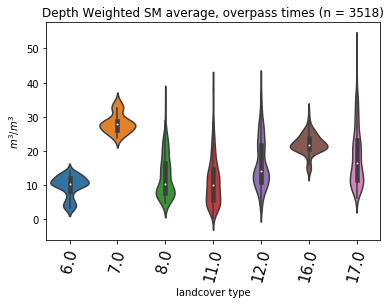

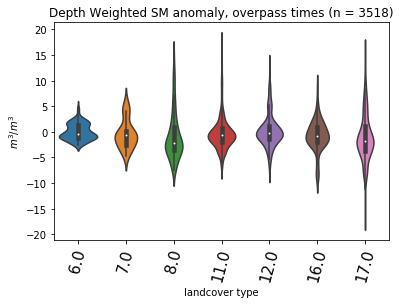

In [144]:
# Plot depth weighted sum of SM violin plot for each lc type only during overpass dates 
p=sns.violinplot(x="lc_type", y="wa", data=analysis_df)
plt.title("Depth Weighted SM average, overpass times (n = {})".format(str(len(analysis_df))))
plt.xlabel("landcover type")
print(plt.gca().get_xticklabels())
# p.set_xticklabels([nlcd[k] for k in plt.gca().get_xticklabels()])
plt.xticks(rotation=75, size = 15)
plt.ylabel("$m^3/ m^3$")
plt.show()

# Plot anomalies of SM violin plot for each lc type only during overpass dates 
p2 = sns.violinplot(x="lc_type", y="wa_anom", data=analysis_df)
# plt.title("Depth Weighted SM anomaly ($X_i' = X_i - \bar{x} $)" + ", overpass times (n = {})".format(str(len(analysis_df))))
plt.title("Depth Weighted SM anomaly, overpass times (n = {})".format(str(len(analysis_df))))

plt.xlabel("landcover type")
plt.ylabel("$m^3/ m^3$")
plt.xticks(rotation=75, size = 15)
# p2.set_xticklabels(lclabels)

plt.show()

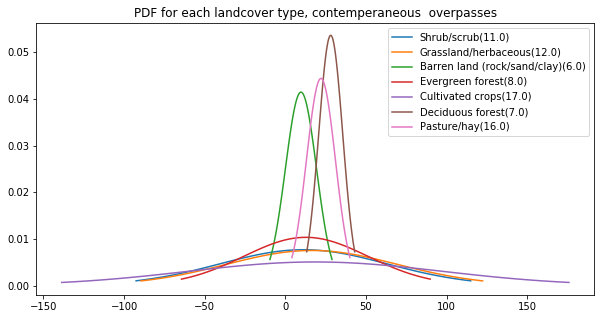

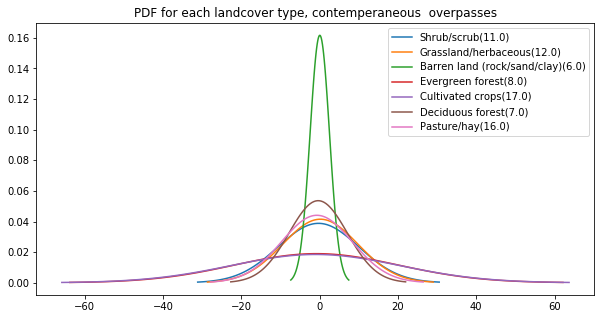

In [84]:
plt.figure(figsize =(10,5))

for i in analysis_df.lc_type.unique():
    lcdf = analysis_df[analysis_df.lc_type==i]
    lctype = lcdf.lc_type.unique()[0]
    mu = np.mean(lcdf.wa.values)
    sigma = np.var(lcdf.wa.values)
    x = np.linspace(mu - 2*sigma, mu + 2*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label = nlcd[lctype]+ "({})".format(lctype) )

plt.title("PDF for each landcover type, contemperaneous  overpasses")
plt.legend()
plt.show()

plt.figure(figsize =(10,5))

for i in analysis_df.lc_type.unique():
    lcdf = analysis_df[analysis_df.lc_type==i]
    lctype = lcdf.lc_type.unique()[0]
    mu = np.mean(lcdf.wa_anom.values)
    sigma = np.var(lcdf.wa_anom.values)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label = nlcd[lctype]+ "({})".format(lctype) )

plt.title("PDF for each landcover type, contemperaneous  overpasses")
plt.legend()
plt.show()

In [132]:
# Print the variances per lc type for weighted avg
print("Weighted Average variance: \n")

for i in analysis_df.lc_type.unique():
    lcdf = analysis_df[analysis_df.lc_type==i]
    lctype = lcdf.lc_type.unique()[0]
    sigma = np.var(lcdf.wa.values)
    mu = np.mean(lcdf.wa.values)
    print(lctype, nlcd[lctype], "variance = ", round(sigma,2), "mean = ", round(mu,2))

Weighted Average variance: 

11.0 Shrub/scrub variance =  51.88 mean =  11.22
12.0 Grassland/herbaceous variance =  52.97 mean =  16.45
6.0 Barren land (rock/sand/clay) variance =  9.63 mean =  9.71
8.0 Evergreen forest variance =  38.56 mean =  12.74
17.0 Cultivated crops variance =  78.66 mean =  18.61
7.0 Deciduous forest variance =  7.44 mean =  28.15
16.0 Pasture/hay variance =  8.99 mean =  22.09


In [145]:

# Print the variances per lc type for weighted avg anomaly
print("Weighted Average Anomaly variance: \n")

for i in analysis_df.lc_type.unique():
    lcdf = analysis_df[analysis_df.lc_type==i]
    lctype = lcdf.lc_type.unique()[0]
    sigma = np.var(lcdf.wa_anom.values)
    mu = np.mean(lcdf.wa_anom.values)
    print(lctype, nlcd[lctype], "variance = ", round(sigma,2), "mean = ", round(mu,2))

Weighted Average Anomaly variance: 

11.0 Shrub/scrub variance =  10.28 mean =  -0.32
12.0 Grassland/herbaceous variance =  9.61 mean =  0.17
6.0 Barren land (rock/sand/clay) variance =  2.47 mean =  0.03
8.0 Evergreen forest variance =  21.0 mean =  -0.84
17.0 Cultivated crops variance =  21.6 mean =  -1.08
7.0 Deciduous forest variance =  7.44 mean =  -0.39
16.0 Pasture/hay variance =  9.05 mean =  -0.73


In [87]:
# N samples per landcover type 
analysis_df.lc_type.value_counts()

11.0    1393
17.0    1123
12.0     464
8.0      217
6.0      147
16.0     144
7.0       30
Name: lc_type, dtype: int64

In [88]:
# All times 

In [124]:
for k,v in lcstats.items():
    print(k, nlcd[k], " variance = ", round(np.var(v[-1]),2), "%", "mean = ", round(np.mean(v[-2]),2), "%")

12 Grassland/herbaceous  variance =  62.22 % mean =  60.2 %
11 Shrub/scrub  variance =  7.28 % mean =  15.65 %
17 Cultivated crops  variance =  15.19 % mean =  19.58 %
7 Deciduous forest  variance =  10.14 % mean =  46.05 %
16 Pasture/hay  variance =  9.59 % mean =  71.45 %
8 Evergreen forest  variance =  26.81 % mean =  12.45 %
6 Barren land (rock/sand/clay)  variance =  2.03 % mean =  17.53 %


In [111]:
lcdat = [v[-2] for k,v in lcstats.items()]
lckeys = [k for k,v in lcstats.items()]
lclabels = [nlcd[k] for k,v in lcstats.items()]

lcwa_anom = [v[-1] for k,v in lcstats.items()]

In [151]:
dwa = dict(zip(lckeys, lcdat))
wadf = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dwa.items()]))
# wadf.columns = lclabels

dwa_anom = dict(zip(lckeys, lcwa_anom))
wadf_anom = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dwa_anom.items()]))
# wadf_anom.columns = lclabels

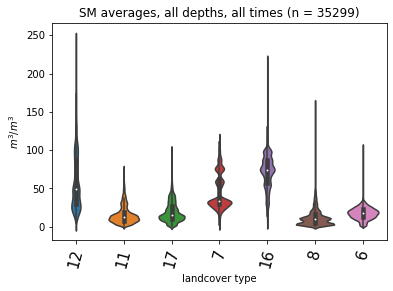

In [152]:
sns.violinplot(data=wadf)
plt.title("SM averages, all depths, all times (n = {})".format(str(len(wadf))))
plt.xlabel("landcover type")
plt.ylabel("$m^3/ m^3$")
plt.xticks(rotation=75, size = 15)
plt.show()

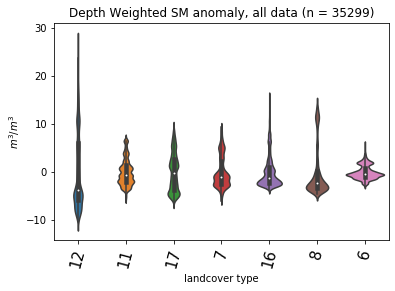

In [153]:
# plt.title("Depth Weighted SM anomaly $X_i' = X_i - \mu_X $, all data (n = {})".format(str(len(wadf_anom))))
plt.title("Depth Weighted SM anomaly, all data (n = {})".format(str(len(wadf_anom))))
sns.violinplot(data=wadf_anom)
plt.xlabel("landcover type")
plt.xticks(rotation=75, size = 15)

plt.ylabel("$m^3/ m^3$")
plt.show()

In [147]:
# means and variances of depth weighted sm
for i in wadf.columns:
    print(i, "mean = ",np.mean(wadf[i]), "var = ", np.var(wadf[i]))

Grassland/herbaceous mean =  60.200463043113565 var =  1478.2185592578141
Shrub/scrub mean =  15.652959184340382 var =  122.53112479357736
Cultivated crops mean =  19.583964404765354 var =  168.32840466448675
Deciduous forest mean =  46.05059048210542 var =  513.3778146436948
Pasture/hay mean =  71.45024537624661 var =  446.53100156057013
Evergreen forest mean =  12.449001275112636 var =  134.0974456356324
Barren land (rock/sand/clay) mean =  17.53392721606844 var =  55.952179318622164


In [95]:
# means and variances of depth weighted sm anomaly 
for i in wadf_anom.columns:
    print(i, "mean = ",np.mean(wadf_anom[i]), "var = ", np.var(wadf_anom[i]))

Grassland/herbaceous mean =  60.200463043113565 var =  1478.2185592578141
Shrub/scrub mean =  15.652959184340382 var =  122.53112479357736
Cultivated crops mean =  19.583964404765354 var =  168.32840466448675
Deciduous forest mean =  46.05059048210542 var =  513.3778146436948
Pasture/hay mean =  71.45024537624661 var =  446.53100156057013
Evergreen forest mean =  12.449001275112636 var =  134.0974456356324
Barren land (rock/sand/clay) mean =  17.53392721606844 var =  55.952179318622164


In [ ]:
# 3 am to 7 am daily

In [102]:
len(lcstats_daily[12][-2])

3972

In [107]:
lcdat_d = [v[-2] for k,v in lcstats_daily.items()]
lcwa_anom_d = [v[-1] for k,v in lcstats_daily.items()]

In [154]:
dwa_d = dict(zip(lckeys, lcdat_d))
wadf_d = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dwa_d.items()]))
# wadf_d.columns = lclabels

dwa_anom_d = dict(zip(lckeys, lcwa_anom_d))
wadf_anom_d = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dwa_anom_d.items()]))
# wadf_anom_d.columns = lclabels

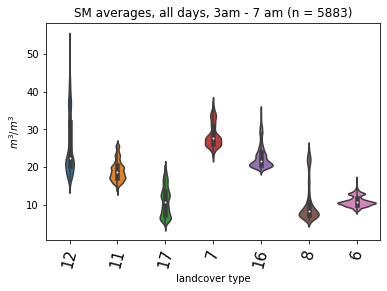

In [155]:
sns.violinplot(data=wadf_d)
plt.title("SM averages, all days, 3am - 7 am (n = {})".format(str(len(wadf_d))))
plt.xlabel("landcover type")
plt.ylabel("$m^3/ m^3$")
plt.xticks(rotation=75, size = 15)
plt.show()

In [126]:
for k,v in lcstats_daily.items():
    print(k, nlcd[k], " variance = ", round(np.var(v[-1]),2), "%", "mean = ", round(np.mean(v[-2]),2), "%")

12 Grassland/herbaceous  variance =  62.43 % mean =  26.11 %
11 Shrub/scrub  variance =  7.25 % mean =  19.16 %
17 Cultivated crops  variance =  15.22 % mean =  10.99 %
7 Deciduous forest  variance =  10.07 % mean =  28.55 %
16 Pasture/hay  variance =  9.57 % mean =  22.82 %
8 Evergreen forest  variance =  26.85 % mean =  10.58 %
6 Barren land (rock/sand/clay)  variance =  1.99 % mean =  11.04 %


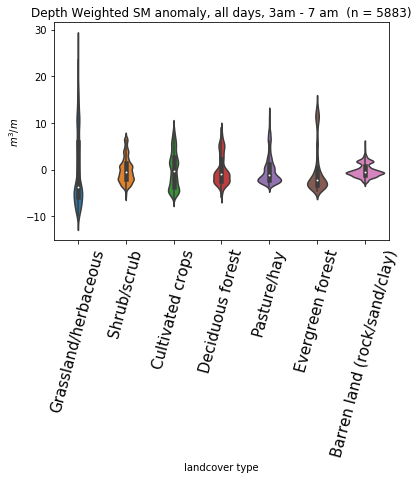

In [149]:
# plt.title("Depth Weighted SM anomaly all data (n = {})".format(str(len(wadf_anom_d))))
plt.title("Depth Weighted SM anomaly, all days, 3am - 7 am  (n = {})".format(str(len(wadf_anom_d))))

sns.violinplot(data=wadf_anom_d)
plt.xlabel("landcover type")
plt.xticks(rotation=75, size = 15)

plt.ylabel("$m^3/ m$")
plt.show()

In [41]:
# For each lc type, whats the mean and variance for all data 
for k,v in lcstats.items():
    print(k, nlcd[k], "variance = ", round(v[1],2), "%", "mean = ", round(v[0],2), "%")

12 Grassland/herbaceous variance =  20.98 % mean =  71.52 %
11 Shrub/scrub variance =  16.15 % mean =  21.91 %
17 Cultivated crops variance =  8.86 % mean =  27.83 %
7 Deciduous forest variance =  23.24 % mean =  19.4 %
16 Pasture/hay variance =  17.4 % mean =  17.35 %
8 Evergreen forest variance =  8.69 % mean =  31.32 %
6 Barren land (rock/sand/clay) variance =  8.86 % mean =  5.85 %


In [32]:
# Plot the PDF for each landcover type (all times)

plt.figure(figsize = (10,5))

for k,v in lcstats.items():
    mu = v[0]
    var = v[1]
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label = nlcd[k]+ "({})".format(k) )

plt.title("PDF for each landcover type, all data ")
plt.legend()
plt.show()

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 720x360 with 0 Axes>

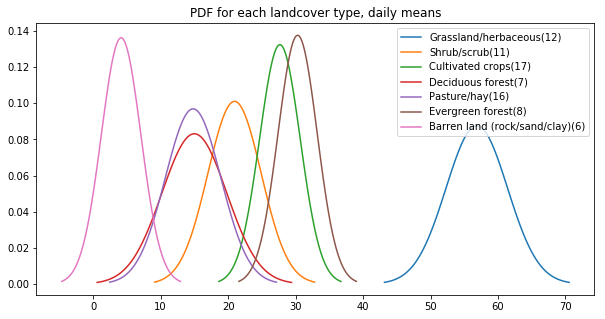

In [43]:
# Plot the PDF for each landcover type (daily means)

plt.figure(figsize = (10,5))

for k,v in lcstats_daily.items():
    mu = v[0]
    var = v[1]
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label = nlcd[k]+ "({})".format(k) )

plt.title("PDF for each landcover type, daily means")
plt.legend()
plt.show()

In [ ]:
# Now do for just 6 am 

In [17]:
analysis_df = pd.concat(out_dfs)

In [18]:
analysis_df.to_csv("../data/FINAL_DATA.csv")

In [19]:
# Compile the spatial and temporal stats 

tempdf = []

for k,v in temporal_stats.items():
    sdf = sites[sites.id == k]
    sdf['sm_mean_t'] = v[0]
    sdf['sm_var_t'] = v[1]
    tempdf.append(sdf)

spatialdf = []

for k,v in spatial_stats.items():
    sdf = sites[sites.id == k]
    sdf['sm_mean_s'] = v[0]
    sdf['sm_var_s'] = v[1]
    spatialdf.append(sdf)

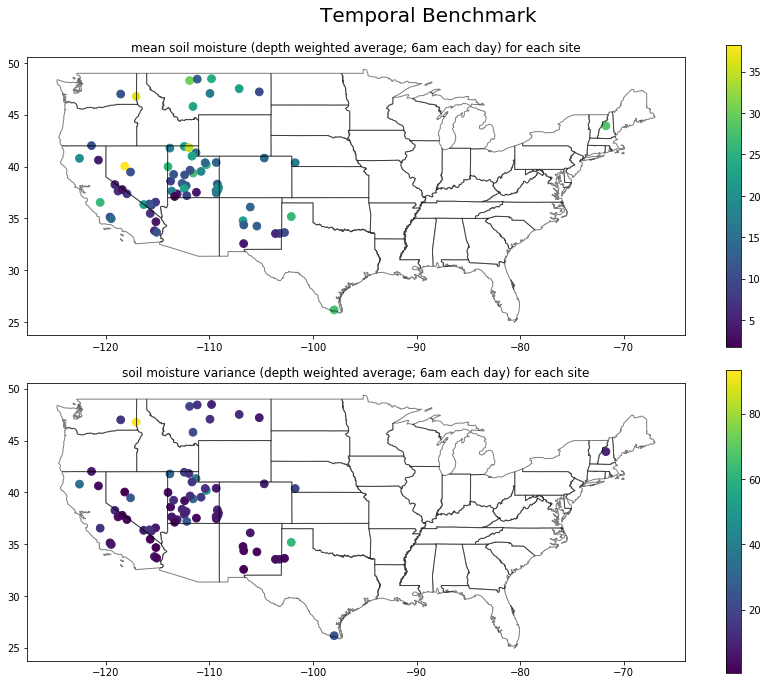

In [20]:
fig, ax = plt.subplots(nrows = 2,figsize = (12,10))

fig.suptitle("Temporal Benchmark", size = 20)

ax[0].set_title("mean soil moisture (depth weighted average; 6am each day) for each site")
pd.concat(tempdf).plot(ax = ax[0], column = "sm_mean_t",markersize = 60, legend = True)
states.plot(ax = ax[0], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

ax[1].set_title("soil moisture variance (depth weighted average; 6am each day) for each site")
pd.concat(tempdf).plot(ax = ax[1], column = "sm_var_t",markersize = 60, legend = True)
states.plot(ax = ax[1], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

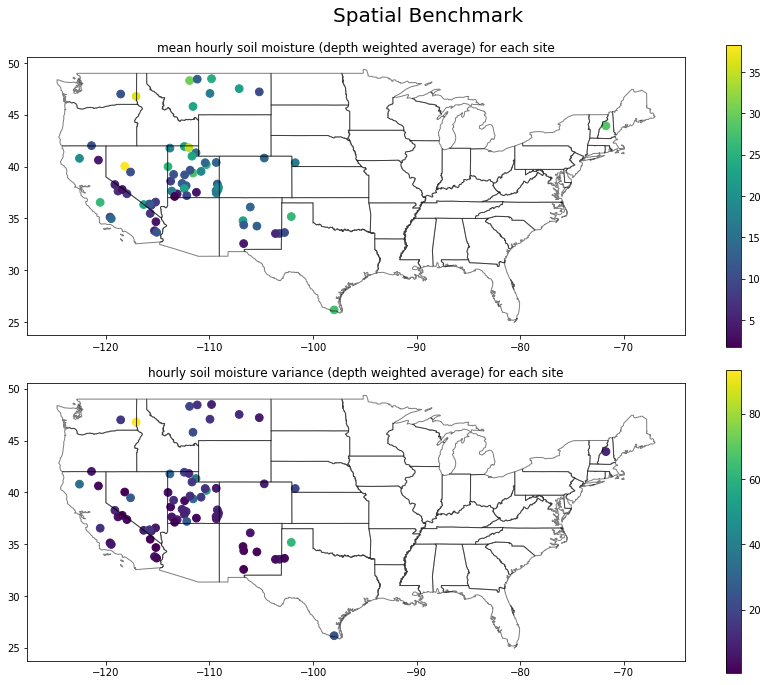

In [21]:
fig, ax = plt.subplots(nrows = 2,figsize = (12,10))

fig.suptitle("Spatial Benchmark", size = 20)

ax[0].set_title("mean hourly soil moisture (depth weighted average) for each site")
pd.concat(spatialdf).plot(ax = ax[0], column = "sm_mean_s",markersize = 60, legend = True)
states.plot(ax = ax[0], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

ax[1].set_title("hourly soil moisture variance (depth weighted average) for each site")
pd.concat(spatialdf).plot(ax = ax[1], column = "sm_var_s",markersize = 60, legend = True)
states.plot(ax = ax[1], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

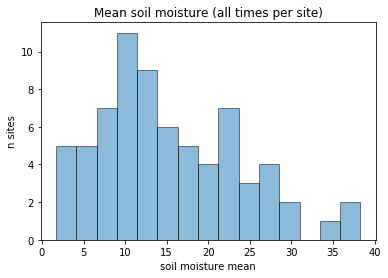

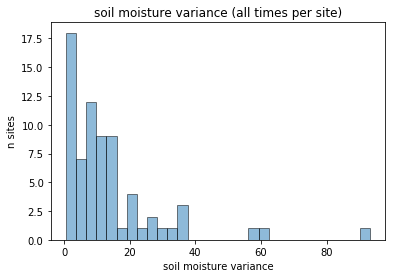

In [22]:
plt.hist(pd.concat(tempdf).sm_mean_t.values, bins = 15, alpha = 0.5, edgecolor='black',)
plt.title("Mean soil moisture (all times per site)")
plt.xlabel("soil moisture mean")
plt.ylabel("n sites")
plt.show()
plt.hist(pd.concat(tempdf).sm_var_t.values, bins = 30, alpha = 0.5, edgecolor='black',)
plt.title("soil moisture variance (all times per site)")
plt.xlabel("soil moisture variance")
plt.ylabel("n sites")
plt.show()

In [137]:
plt.hist(pd.concat(spatialdf).sm_mean_s.values, bins = 15, alpha = 0.5, edgecolor='black',)
plt.title("Mean soil moisture (6 am daily)")
plt.xlabel("soil moisture mean")
plt.ylabel("n sites")
plt.show()
plt.hist(pd.concat(spatialdf).sm_var_s.values, bins = 30, alpha = 0.5, edgecolor='black',)
plt.title("soil moisture variance (6 am daily)")
plt.xlabel("soil moisture variance")
plt.ylabel("n sites")
plt.show()

NameError: name 'spatialdf' is not defined

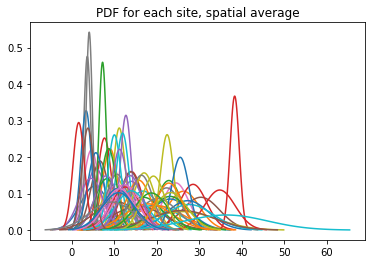

Text(0.5, 1.0, 'PDF for each site, temporal average')

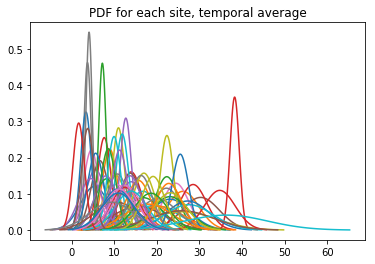

In [24]:
for k,v in spatial_stats.items():
    mu = v[0]
    var = v[1]
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.title("PDF for each site, spatial average")
plt.show()

for k,v in temporal_stats.items():
    mu = v[0]
    var = v[1]
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.title("PDF for each site, temporal average")

In [25]:
meandiff = {}
vardiff = {}
for k,v in spatial_stats.items():
    meandiff[k] = (v[0] - temporal_stats[k][0]) * 100
    vardiff[k] = (v[1] - temporal_stats[k][1]) * 100

In [26]:
mean_df = []

for k,v in meandiff.items():
    sdf = sites[sites.id == k]
    sdf['meandiff'] = v
    mean_df.append(sdf)

In [27]:
var_df = []

for k,v in vardiff.items():
    sdf = sites[sites.id == k]
    sdf['vardiff'] = v
    var_df.append(sdf)

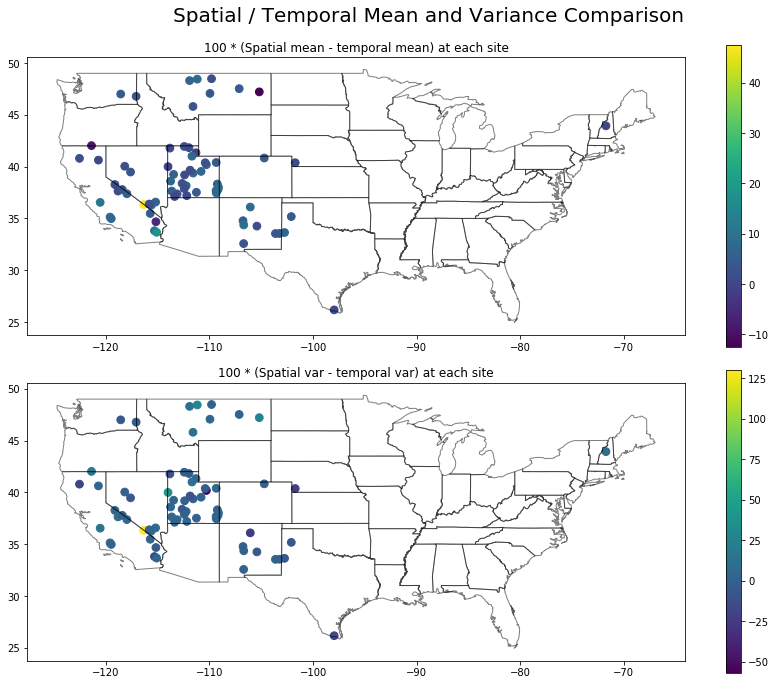

In [28]:
pd.concat(mean_df)
pd.concat(var_df)

fig, ax = plt.subplots(nrows = 2,figsize = (12,10))

fig.suptitle("Spatial / Temporal Mean and Variance Comparison", size = 20)

ax[0].set_title("100 * (Spatial mean - temporal mean) at each site")
pd.concat(mean_df).plot(ax = ax[0], column = "meandiff",markersize = 60, legend = True)
states.plot(ax = ax[0], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

ax[1].set_title("100 * (Spatial var - temporal var) at each site")
pd.concat(var_df).plot(ax = ax[1], column = "vardiff",markersize = 60, legend = True)
states.plot(ax = ax[1], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Make baseline predictions: 

Use the spatial and temporal mean at each site to calculate a baseline RMSE, bias, R^2:

$$R^2 =  1 - \frac {\sum_{i=1}^{n} (x_i - \hat{x})^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2 }$$

$$RMSE =  \sqrt{{ \frac{{\sum_{i=1}^{n} (x_i - \bar{x})^2}} {n} }}$$

$$bias =  \frac {1}{n} {\sum_{i=1}^{n} (x_i - \bar{x})^2 }$$


In [246]:
import math

def average(x):
    assert len(x) > 0
    return float(sum(x)) / len(x)

def pearson_def(x, y):
    assert len(x) == len(y)
    n = len(x)
    assert n > 0
    avg_x = average(x)
    avg_y = average(y)
    diffprod = 0
    xdiff2 = 0
    ydiff2 = 0
    for idx in range(n):
        xdiff = x[idx] - avg_x
        ydiff = y[idx] - avg_y
        diffprod += xdiff * ydiff
        xdiff2 += xdiff * xdiff
        ydiff2 += ydiff * ydiff

    return diffprod / math.sqrt(xdiff2 * ydiff2)

In [247]:
pearson_def(adf.ws,adf.sm_mean_s)

0.8947564817292613

In [ ]:
# See how depth weighted sm varies at each site, 

In [150]:
rmses = []
for i in adf.site.unique():
    sdf = analysis_df[analysis_df.site == i]
    site_rmse = 4

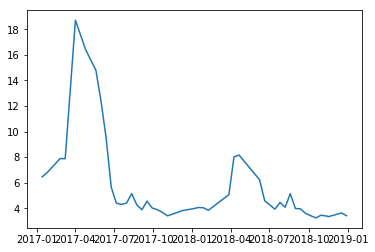

In [144]:
plt.plot(analysis_df[analysis_df.site == 2215.0].ws)

In [104]:
site_means = pd.concat(spatialdf)
site_means.id = site_means.id.astype(np.float64)
# site_means.index = site_means.id
keepcols = [x for x in  site_means.columns if x not in analysis_df.columns]

In [106]:
site_means.id.astype(int)
analysis_df.id.astype(int)
adf = analysis_df.merge(site_means, on='id')

In [121]:
np.sqrt(np.mean((adf.ws - adf.sm_mean_s)**2))

3.8145467861161766

In [129]:
adf.columns

Index(['site', 'precip', 'rzsm', 'psi_rz', 'ssm', 'psi_s', 'lc_type', 'vv',
       'hv', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B1_filt', 'B2_filt',
       'B3_filt', 'B4_filt', 'B5_filt', 'B6_filt', 'B7_filt', 'ndvi', 'ndmi',
       'evi', 'id', 'elev_x', 'clay_fract_x', 'silt_fract_x', 'sand_fract_x',
       'a_x', 'b_x', 'ws', 'ntwk', 'state', 'site_name', 'ts', 'start', 'lat',
       'lon', 'elev_y', 'county', 'huc', 'clay_fract_y', 'silt_fract_y',
       'sand_fract_y', 'a_y', 'b_y', 'geometry', 'sm_mean_s', 'sm_var_s'],
      dtype='object')

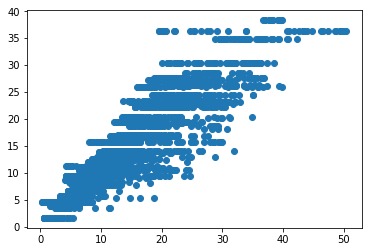

In [248]:
plt.scatter(adf.ws,adf.sm_mean_s)

In [250]:
    # Calc R^2
    A = np.vstack([adf.sm_mean_s, np.ones(len(adf.sm_mean_s))]).T
    solution = np.linalg.lstsq(A, adf.ws)
    m, c = solution[0]
    residuals = solution[1]
    r2 = 1 - residuals / sum((adf.ws - adf.ws.mean())**2) 

In [253]:
np.sqrt(r2)

array([0.89475648])

In [254]:
pearson_def(adf.ws,adf.sm_mean_s)

0.8947564817292613

In [124]:
# Global RMSE
spatial_rmse = ((adf.ws - adf.sm_mean_s) ** 2).mean() ** .5
spatial_bias = ((adf.ws - adf.sm_mean_s)).mean()

print(spatial_rmse)
print(spatial_bias)


3.8145467861161766
-0.5331723505228146


In [156]:
# Site specific RMSE 
rmses = []
biases = []
variances = []
for i in adf.site.unique():
    sdf = adf[adf.site == i]
    site_rmse = ((sdf.ws - sdf.sm_mean_s) ** 2).mean() ** .5
    site_var = np.var(sdf.ws)
    site_bias = ((sdf.ws - sdf.sm_mean_s)).mean()
    variances.append(site_var)
    rmses.append(site_rmse)
    biases.append(site_bias)

(array([50., 12.,  5.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  0.35122053,  13.19257488,  26.03392924,  38.8752836 ,
         51.71663795,  64.55799231,  77.39934667,  90.24070103,
        103.08205538, 115.92340974, 128.7647641 ]),
 <a list of 10 Patch objects>)

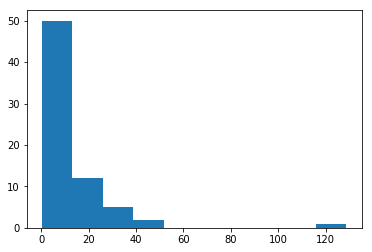

In [159]:
plt.hist(np.array(variances))

In [162]:
np.mean(variances)

12.391409182360793

In [ ]:
# Setup for the LSTM 

In [ ]:
analysis_df.drop(["id"], axis = 1, inplace = True)
df = analysis_df.copy()

In [ ]:
# Drop nonconsecutive rows 

t = df.copy()

filtered = []

for i in t.site.unique():
    sdf = t[t.site==i]
    
    for i in sdf.index:
        begin = i
        end = begin + pd.Timedelta(days=12)
        temp = sdf[begin:end]
        num_points = len(temp)
        if num_points<1:
            print(t)
        else:
            filtered.append(temp)

filt = pd.concat(filtered).dropna()

df = filt.copy()

In [ ]:
# Calc 12 day means 
df = df.groupby(['site']).resample('12D').mean().fillna(np.nan).dropna()

In [ ]:
# Drop the non interpolated landsat bands
df.drop(["B1", "B2", "B3", "B4", "B5", "B6", "B7"], axis = 1,inplace = True)
df.rename(columns={'B1_filt': 'B1', 'B2_filt': 'B2','B3_filt': 'B3','B4_filt': 'B4','B5_filt': 'B5','B6_filt': 'B6','B7_filt': 'B7'}, inplace=True)

In [ ]:
# One hot encode the landcover types 
one_hot = pd.get_dummies(df.lc_type, drop_first=True )
rdf = pd.concat([df, one_hot], axis = 1)
rdf = rdf.drop(["lc_type"], axis = 1)
df = rdf.dropna()

# Convert hte col names to strings 
df.columns = df.columns.map(str)

In [ ]:
# Add the time lagged predictors 
s1 = df.groupby(level="site").shift(1)
# s1 = df.groupby("site").shift(1)
df1 = df.join(s1.rename(columns=lambda x: x+"_t1"))

s2 = df.groupby(level="site").shift(2)
# s2 = df.groupby("site").shift(2)
df2 = df1.join(s2.rename(columns=lambda x: x+"_t2"))

df3 = df2.copy()

In [ ]:
# Drop irrelevant columns 

dropstrs = ['site','precip', 'rzsm', 'ssm', 'psi_rz', "psi_s", "ws_"]
dropcols = []

for i in df3.columns:
    for x in dropstrs:
        if x in i:
            dropcols.append(i)
            
df3 = df3.drop(dropcols, axis = 1)
# df = df3.dropna()

In [ ]:
# Reset the index and drop nans 
df = df3.reset_index(level='site')
df = df.dropna()

In [ ]:
# Modeling options

EPOCHS = 100
BATCHSIZE = 50
DROPOUT = 0.25
LOSS = 'mse'

Areg = regularizers.l1(0.00005)
Breg = regularizers.l2(0.0001)
Kreg = regularizers.l2(1e-15)
Rreg = regularizers.l2(1e-15)

def build_model(input_shape):
    # make the model 
    model = Sequential()
    
    model.add(LSTM(100, input_shape=input_shape, dropout = 0.15,recurrent_dropout=0.15,return_sequences=True,bias_regularizer= Breg))
#     model.add(LSTM(50, input_shape=input_shape, dropout = 0.15,recurrent_dropout=0.15,return_sequences=True,bias_regularizer= Breg))
    model.add(Dropout(0.2))
    model.add(LSTM(10, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.20,bias_regularizer= Breg))

    model.add(Dense(1))
    model.compile(loss=LOSS, optimizer= optimizers.Nadam(lr=0.01),
                  metrics=['mse'])
    
    return model

# Leave one site out CV

In [ ]:
out = {"train_preds":[],
       "test_preds":[],
       "train_act":[],
       "test_act":[]  
        }

In [ ]:
# Randomly loop through the sites 
for i in random.sample(set(df.site.unique()), len(df.site.unique())):

    print("Processing {}".format(i))
    
    # Select the random site as test, all other sites as train 
    sdf = df[df.site == i]
    y_test = sdf.ws
    X_test = sdf.drop(["site","ws"], axis=1)

    nsdf = df[df.site != i]
    y_train = nsdf.ws 
    X_train = nsdf.drop(["site","ws"], axis=1)
        
    # Scale data
    transformer_x = StandardScaler().fit(X_train)
    transformer_y = StandardScaler().fit(np.array(y_train).reshape(-1, 1)) 
    
#     transformer_x = MinMaxScaler(feature_range=(0,1)).fit(X_train)
#     transformer_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(y_train).reshape(-1, 1)) 
    
    X_train = transformer_x.transform(X_train)
    y_train = transformer_y.transform(np.array(y_train).reshape(-1, 1))
    X_test = transformer_x.transform(X_test)
    y_test = transformer_y.transform(np.array(y_test).reshape(-1, 1))
    
    # LSTM params
    n_lags = 3
    n_features = 19

    X_train = X_train.reshape((X_train.shape[0], n_lags, 24))
    X_test = X_test.reshape((X_test.shape[0], n_lags, 24))

    input_shape=(X_train.shape[1], X_train.shape[2])
    
    model = build_model(input_shape=input_shape)
    
    # Fit
#     model.fit(X_train, y_train, epochs=1000, batch_size=1000, verbose=1)
    
    train_history = model.fit(X_train, y_train,epochs = 500,
                    batch_size=500,
                    verbose=0, validation_data=(X_test, y_test))
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    val_acc = train_history.history['val_mean_squared_error']

    # Get the predictions
    yhat_train = model.predict(X_train)
    
    trainPredict = transformer_y.inverse_transform(yhat_train.reshape(-1,1))
    trainY = transformer_y.inverse_transform(y_train)
    
    yhat = model.predict(X_test)
    testPredict = transformer_y.inverse_transform(yhat.reshape(-1,1))
    testY = transformer_y.inverse_transform(y_test)

    trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))
    
    out["test_preds"] = testPredict
    out["train_preds"] = trainPredict
    
    out["test_act"] = testY
    out["train_act"] = trainY
    
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['loss', 'val_loss'])
    plt.show()

    plt.scatter(trainPredict, trainY)
    plt.scatter(testPredict, testY)
    plt.plot([0, 100], [0, 100], 'k-')
    plt.title('''
                train set RMSE = {}
                test set RMSE = {}
                '''.format(round(trainScore,2),round(testScore,2)))

    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()

# K fold CV

In [ ]:
out = {"train_preds":[[]],
       "test_preds":[[]],
       "train_act":[[]],
       "test_act":[[]]  
        }

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=10)
Y = df.ws.values
X = df.loc[:, df.columns != 'ws'].drop("site", axis = 1).values

In [ ]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Scale data
#     transformer_x = StandardScaler().fit(X_train)
#     transformer_y = StandardScaler().fit(np.array(y_train).reshape(-1, 1)) 
    
    transformer_x = MinMaxScaler(feature_range=(0,1)).fit(X_train)
    transformer_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(y_train).reshape(-1, 1)) 
    
    X_train = transformer_x.transform(X_train)
    y_train = transformer_y.transform(np.array(y_train).reshape(-1, 1))
    X_test = transformer_x.transform(X_test)
    y_test = transformer_y.transform(np.array(y_test).reshape(-1, 1))
    
    # LSTM params
    n_lags = 3
    n_features = 24

    # Reshape inputs
    X_train = X_train.reshape((X_train.shape[0], n_lags, n_features))
    X_test = X_test.reshape((X_test.shape[0], n_lags, n_features))

    input_shape=(X_train.shape[1], X_train.shape[2])
    
    # Build model
    model = build_model(input_shape=input_shape)

    # Fit model
    train_history = model.fit(X_train, y_train, epochs=1000, batch_size=250, verbose=1,validation_data=(X_test, y_test))
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    val_acc = train_history.history['val_mean_squared_error']
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
    # evaluate the model
    scores = model.evaluate(X_test, y_test, verbose=1)
    print("%s: %.2f%% (+/- %.2f%%)" % (model.metrics_names[1],np.std(scores[1]*100), scores[1]*100))

    # Get the predictions
    yhat_train = model.predict(X_train)
    trainPredict = transformer_y.inverse_transform(yhat_train.reshape(-1,1))
    trainY = transformer_y.inverse_transform(y_train)
    
    yhat = model.predict(X_test)
    testPredict = transformer_y.inverse_transform(yhat.reshape(-1,1))
    testY = transformer_y.inverse_transform(y_test)

    # Calc RMSE 
    rmse_test = np.sqrt(np.mean((y_test - testPredict)**2))
    
    trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = np.sqrt(mean_squared_error(y_test, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))
    print(rmse_test)
    
    # Calc R^2
    A = np.vstack([testPredict.reshape(testPredict.shape[0]), np.ones(len(testPredict.reshape(testPredict.shape[0])))]).T
    solution = np.linalg.lstsq(A, testY)
    m, c = solution[0]
    residuals = solution[1]
    r2 = 1 - residuals / sum((testY - testY.mean())**2) 
    
    # Calc ubRMSE
    ubrmse = np.sqrt(np.mean(((testY - np.mean(testY)) - (testPredict - np.mean(testPredict)))**2))
    
    # Calc Bias 
    bias = np.mean(testY - testPredict)
    
    out["test_preds"].append(testPredict)
    out["train_preds"].append(trainPredict)
    
    out["test_act"].append(testY)
    out["train_act"].append(trainY)
    
    # Train / Test loss 
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['loss', 'val_loss'])
    plt.show()

    # Predicted vs actual
    plt.scatter(trainPredict, trainY, alpha = 0.2, label = "train")
    plt.scatter(testPredict, testY, alpha = 0.2, label = "test")
    plt.plot(testY, m*testY + c, 'r', label='y = {}x + {}'.format(str(round(m[0],2)), str(round(c[0],2))))
    plt.plot([0, 100], [0, 100], "gray", label = "1-1 line")
    plt.title('''
                train set RMSE = {}
                test set RMSE = {}
                test set $R^2$ = {}
                test set ubrmse = {}
                test set bias = {}

                '''.format(round(trainScore,2), round(testScore,2),round(r2[0],4), round(ubrmse,3), round(bias,3)))

    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.legend()
    plt.show()

In [ ]:
all_preds = np.array([item for sublist in np.array([x for x in out['test_preds'] if len(x) !=0]) for item in sublist])
all_obs = np.array([item for sublist in np.array([x for x in out['test_act'] if len(x) !=0]) for item in sublist])

In [ ]:
preds = all_preds.reshape(all_preds.shape[0])
obs = all_obs.reshape(all_obs.shape[0])

In [ ]:
A = np.vstack([preds, np.ones(len(preds))]).T
solution = np.linalg.lstsq(A, obs)
m, c = solution[0]
residuals = solution[1]
r2 = 1 - residuals / sum((obs - obs.mean())**2) 

In [ ]:
# KDE for predictions 

xy = np.vstack([obs,preds])
z = gaussian_kde(xy)(xy)

plt.figure(figsize = (7,7))
plt.scatter(all_obs.reshape(all_obs.shape[0]), all_preds.reshape(all_preds.shape[0]), c=z, s=10, cmap = "hot")
plt.plot(obs, m*obs + c, 'b',linewidth=4, label='y = {}x + {}'.format(str(round(m,2)), str(round(c,2))))
plt.plot([0, 100], [0, 100], "gray", label = "1-1 line")
plt.xlim(0, 60)
plt.ylim(0, 60)

plt.xlabel("predicted")
plt.ylabel("actual")
plt.legend()
plt.show()

In [ ]:
# Random Forest 

regressor = RandomForestRegressor(n_estimators=5000, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [ ]:
# Make predictions on test data using the model trained on original data
predictions = regressor.predict(X_test)
# Performance metrics
errors = abs(predictions - y_test)
print('Metrics for Random Forest Trained on Original Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')